# In short

* **Autoencoders**: để nén dữ liệu (bản đồ mực nước)
* **NARX (Nonlinear Autoregressive with Exogenous Inputs)**: Dự đoán **chuỗi thời gian** của bản đồ lũ

# Data

## Rainfall

* Dạng **time series** 
* **914** sự kiện mưa, mỗi sự kiện kéo dài **10m đến 12h**
* Lượng mưa dao động từ 14.3mm đến 84.8mm
* là thành phần **Exogenous** cho **NARX**

## Water level maps

* Dữ liệu ảnh (Maps 2D)

* Không rõ ràng bao nhiêu ảnh, từ thời điểm nào, môi trường, điều kiện nào

* Lấy từ **914 sự kiện mưa**
* Khoảng cách thời gian **5 phút** một ảnh
* 1 ảnh toàn thể bao gồm $ 5 km^2$ vùng đô thị
* 1 pixel = **6x6m**
* 1 ảnh toàn thể được chia làm 4 (**có overlap**) cỡ: **198x252**

> Chuỗi ảnh xét theo thời gian là chuỗi thời gian không liên tục

# Model

## Mạng autoencoder

🎯 **Mục tiêu**:
* Giảm kích thước dữ liệu bằng cách **encode** vào không gian ẩn (**latent space**)
* Tăng hiệu suất tính toán, tránh giới hạn bộ nhớ

⚙️ **Architecture**:
* Dựa trên **U-Net**, nhưng **bỏ** các skip connections để tập trung vào nén data
* Sử dụng **2 lớp convolution**, mỗi lớp:
    * 64 bộ lọc
    * kernel: 3x3
    * stride: 3
* **Bottleneck**:
    * vector kích thước **150**
* **Decoder**:
    * dùng **deconvolution** bằng **Conv2DTranspose** để decode tương tự encode
* **Activation function**:
    * ở tất cả các tầng, sử dụng **Leaky ReLU**
    * đầu ra: **Sigmoid**

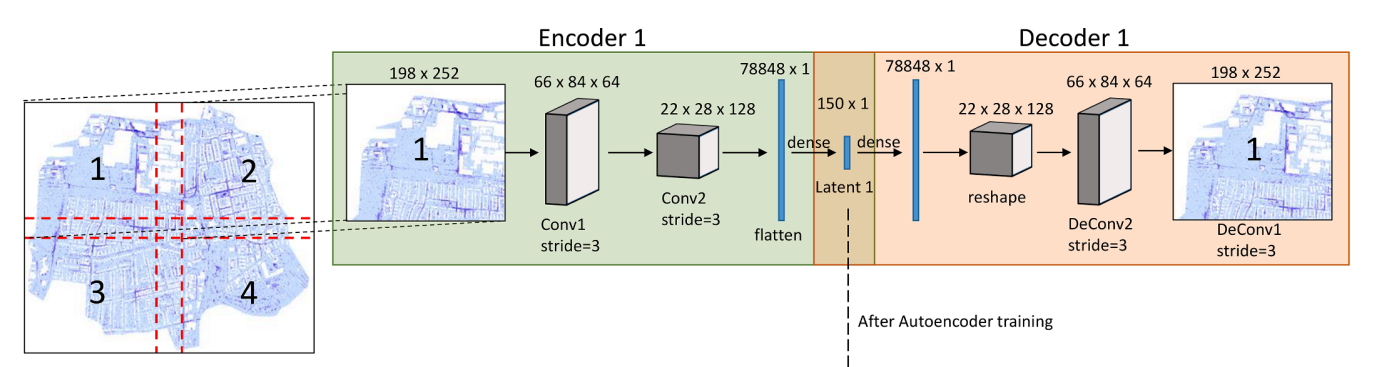

📤 **Output**:
* **Latent space**: 
    * phiên bản **nén** của **mực nước**
    * Làm **đầu vào** cho mô hình dự báo **NARX**

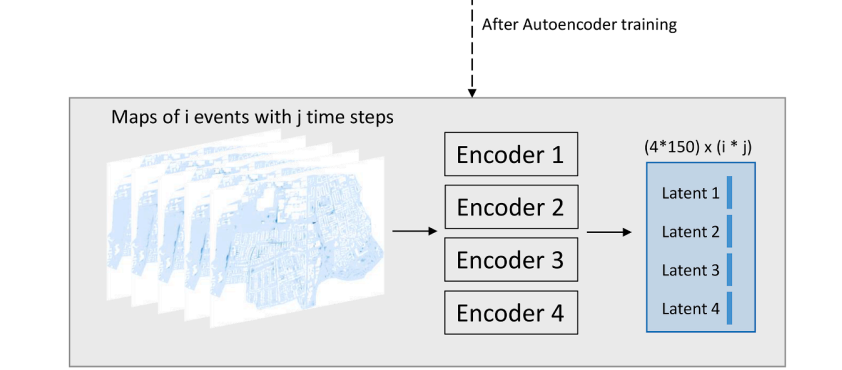

<p style="text-align: center;">4 Encoder cho 4 subdomains</p>

* Đầu ra của **Autoencoder**: (Sau bước decoder):
    * là **bản đồ mực nước** được tái tạo
    * Dùng để **đánh giá** chất lượng **Autoencoder**

## Mạng NARX

🎯 **Mục tiêu**:
* Dự đoán bản đồ mực nước ở thời điểm thiếp theo

⚙️ **Architecture**

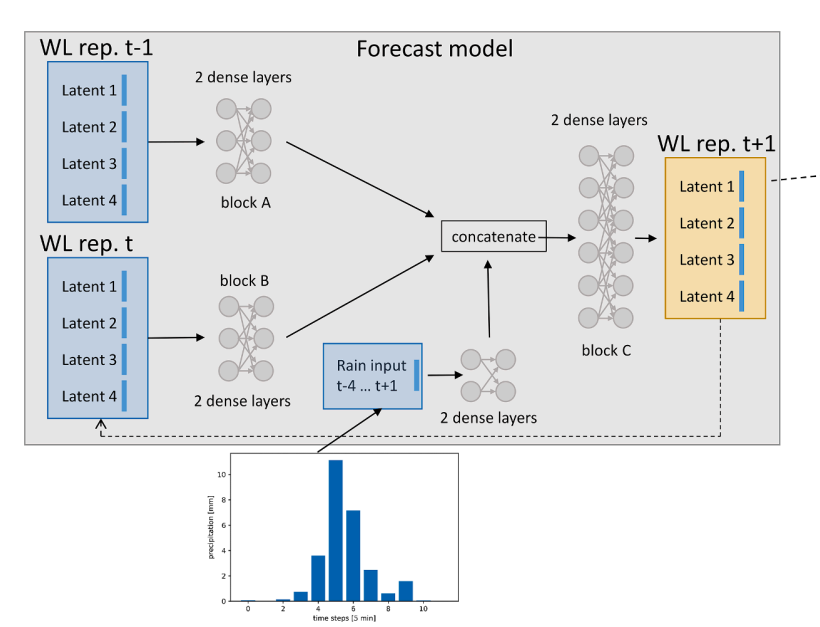

* **3 inputs**:
    * bản đồ mực nước hiện tại (t) $\rightarrow \mathbf{wl}_{i,j}$
    * bản đồ mực nước trc đó (t-1) $\rightarrow \mathbf{wl}_{i,j-1}$
    * Chuỗi lượng mưa trong **25 phút** gần nhất $\rightarrow \mathbf{p}_{i,j}$ (5 bước)

> Dữ liệu bản đồ mực nước biểu diễn ở **vector 150 chiều** đã nén bởi **Encoder**

📌 **3 Khối chính xử lý 3 input**

🔹**Block A** xử lý $\mathbf{wl}_{i,j}$:
* Dense(300, act=LeakyReLU)
* Dense(300, act=LeakyReLU)
* Noise layer (std = 0.3 để tránh overfit)

🔹**Block B** xử lý $\mathbf{wl}_{i,j-1}$:
* Dense(300, act=LeakyReLU)
* Dense(300, act=LeakyReLU)
* Noise layer (std = 0.15)

🔹**Block rain** xử lý $\mathbf{p}_{i,j}$:
* Dense(150, act=LeakyReLU)
* Dense(150, act=LeakyReLU)
* Noise layer (std = 0.3 để tránh overfit)

📌 **Hợp nhất 3 khối**:
* Dense(600, act=LeakyReLU)
* Dense(600, act=LeakyReLU)
* Dense(150, act=Sigmoid) $\rightarrow$ dự đoán **vector latent** của bước tiếp theo $\mathbf{wl}_{i,j+1}$

👉 **Vector** $\mathbf{wl}_{i,j+1}$ sau đó được giải nén bằng **Decoder** để được bản đồ mực nước đầy đủ

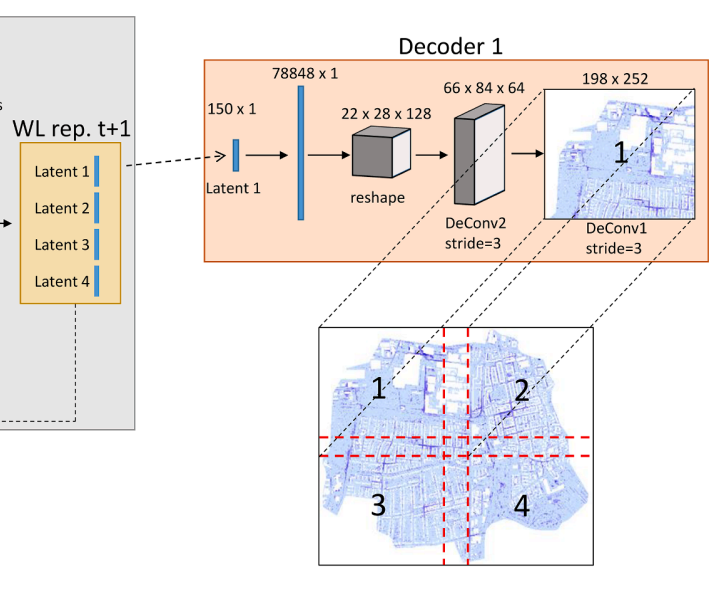

# Experiment

## Preprocess

* Chuẩn hóa dữ liệu từ 0.2 đến 1 cho các ô có nước
* Đặt giá trị 0 cho các **ô không bao giờ bị nhập**

## Config

**Autoencoder**:
* loss: **MAE** (chỉ tính trên ô có nước)
* batch size: max
* Optimizer: **Adam**
* learning rate: **0.001**
* early stopping: 5 epochs

**NARX**:
* Optimizer: **SGD**
* learning rate: **0.1**, giảm mỗi 20k steps, **decay factor: 0,8**
* Early stopping: 500 epochs

# Results

## Metrics

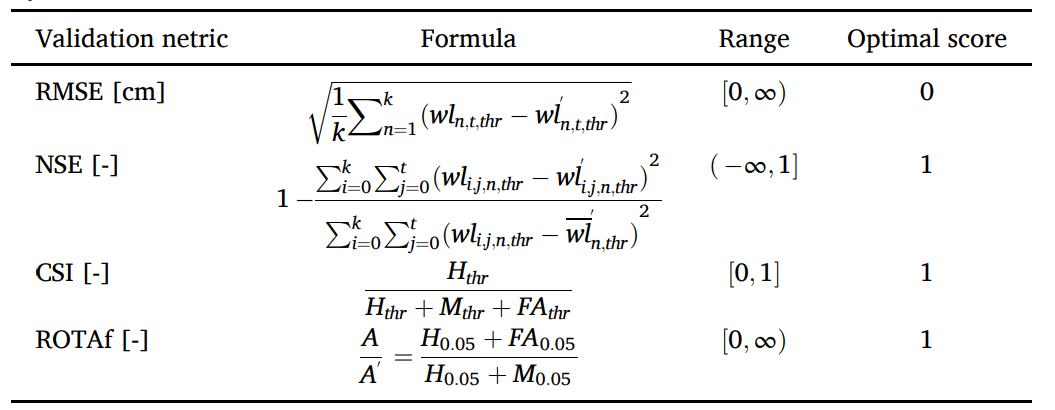

trong đó:
* $wl_{n,t,thr}$: mực nước dự đoán ở pixel `n` tại thời điểm `t`, threshold `thr`
* $wl^{'}_{n,t,thr}$: mực nước mô phỏng với cùng `n,t,thr`
* $H_{thr}$: Số cell **mực nước lớn hơn** `thr` của cả **prediction** và **hydrodynamic** model
* $M_{thr}$: Số cell **mực nước lớn hơn** `thr` của chỉ **hydrodynamic** model
* $FA_{thr}$: Số cell **mực nước lớn hơn** `thr` của chỉ **prediction** model
* $A$: vùng ngập ở prediction
* $A'$: vùng ngập ở hydrodynamic

## Results

✅ **Score**:
* **RMSE** trung bình: ~ 5mm
* **CSI** ~ 0.7 (phản ảnh tốt vùng ngập nặng)
* **ROTAf** ~ 0.956 (phản ảnh gần đúng diện tích ngập thực tế)

✅ **Speed**:
*  gấp 2618 lần so với mô hình vật lý